In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7" -O Dataset.zip && rm -rf /tmp/cookies.txt

--2023-07-08 09:20:17--  https://docs.google.com/uc?export=download&confirm=&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7
Resolving docs.google.com (docs.google.com)... 108.177.126.100, 108.177.126.138, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.100|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-07-08 09:20:18 ERROR 404: Not Found.



In [12]:
!unzip Dataset.zip


Archive:  Dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Dataset.zip or
        Dataset.zip.zip, and cannot find Dataset.zip.ZIP, period.


# **Import Libraries**


In [6]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
#%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## **Select Randomness**

In [7]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!pip install pafy youtube-dl moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.5 MB/s eta 0:00:00


In [8]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# **View the dataset**

In [11]:

plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('Dataset')

for counter, random_index in enumerate(range(len(all_classes_names)), 1):


    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    _, bgr_frame = video_reader.read()

    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

FileNotFoundError: ignored

<Figure size 2000x2000 with 0 Axes>

# **Set Dataset variables**

In [10]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 30

DATASET_DIR = "Dataset"

CLASSES_LIST = ["walking", "fights", "running"]

# **Data Preprocessing**

In [ ]:
def frames_extraction(video_path):


    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):


        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:

features, labels, video_files_paths = create_dataset()

Extracting Data of Class: walking
Extracting Data of Class: fights
Extracting Data of Class: running


In [ ]:

print(features.shape, labels.shape)

(300, 30, 64, 64, 3) (300,)


In [ ]:

one_hot_encoded_labels = to_categorical(labels)

In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# **Model Creation LRCN (Long-term Recurrent Convolutional Network)**

In [ ]:
def create_LRCN_model():

    model = Sequential()


    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

In [ ]:
model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 64, 64, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 16, 16, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 16, 16, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 4, 4, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 4, 4, 128)   

# **Model Training**

In [ ]:

early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)


model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/70
42/42 [==============================] - 19s 408ms/step - loss: 0.7611 - accuracy: 0.5238 - val_loss: 0.4381 - val_accuracy: 0.7018
Epoch 2/70
42/42 [==============================] - 15s 355ms/step - loss: 0.6905 - accuracy: 0.6250 - val_loss: 0.6192 - val_accuracy: 0.7018
Epoch 3/70
42/42 [==============================] - 14s 344ms/step - loss: 0.6772 - accuracy: 0.6905 - val_loss: 0.5577 - val_accuracy: 0.7368
Epoch 4/70
42/42 [==============================] - 15s 349ms/step - loss: 0.5224 - accuracy: 0.7560 - val_loss: 0.4770 - val_accuracy: 0.7719
Epoch 5/70
42/42 [==============================] - 15s 357ms/step - loss: 0.4741 - accuracy: 0.7738 - val_loss: 0.4480 - val_accuracy: 0.7368
Epoch 6/70
42/42 [==============================] - 16s 380ms/step - loss: 0.4609 - accuracy: 0.7619 - val_loss: 0.4194 - val_accuracy: 0.7895
Epoch 7/70
42/42 [==============================] - 15s 349ms/step - loss: 0.4192 - accuracy: 0.7917 - val_loss: 0.4149 - val_accuracy: 0.7544

# **Save the Model**

In [ ]:

model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

# **Plot Loss and Accuracy Graphs while Training**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

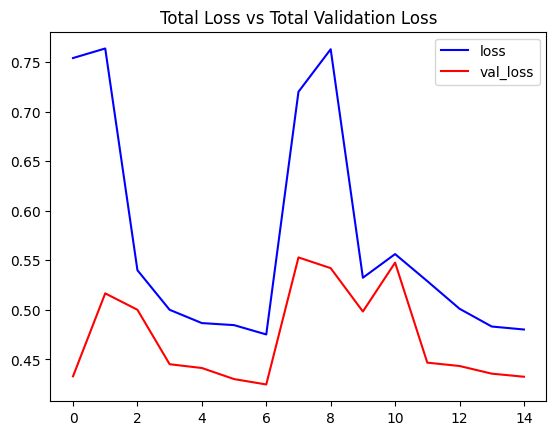

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

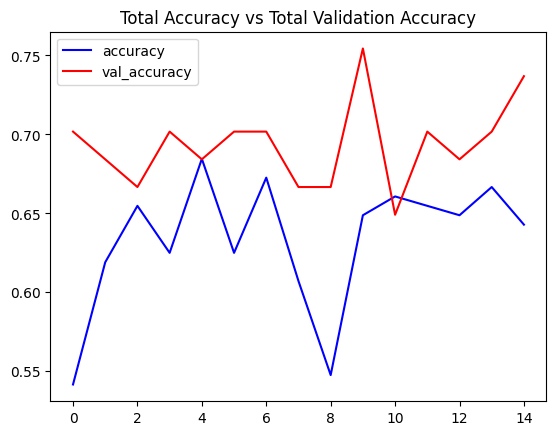

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Accuracy on Test Dataset**

In [ ]:

acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 41ms/step
Accuracy = 89.33333333333333
